# 모델 시각화 (Model Visualization)

학습된 모델의 결과를 시각화하고 분석합니다.

**내용:**
- 복원 결과 비교
- 열화 표현 (z_d) t-SNE 시각화
- 콘텐츠 표현 (z_c) 분석
- Cross-domain transfer 결과

In [11]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

from src.models import CrossDomainDegradationTransfer
from src.data.datasets import get_dataset
from src.data.loader import get_default_transform
from src.utils.metrics import compute_psnr, compute_ssim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 1. 설정

In [12]:
# 경로 설정 - 최신 학습된 모델 사용

CHECKPOINT_PATH = Path('../experiments/corruption_transfer/corruption_transfer_20260114_170439/checkpoint_0071_best.pth')
DATA_ROOT = Path('../data')

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Exists: {CHECKPOINT_PATH.exists()}")

Using device: cuda
Checkpoint: ../experiments/corruption_transfer/corruption_transfer_20260114_170439/checkpoint_0071_best.pth
Exists: True


## 2. 모델 로드

In [13]:
def load_model(checkpoint_path, device):
    """체크포인트에서 모델 로드"""
    model = CrossDomainDegradationTransfer().to(device)
    
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"모델 로드 완료: {checkpoint_path}")
        if 'epoch' in checkpoint:
            print(f"  Epoch: {checkpoint['epoch']}")
    else:
        print(f"체크포인트가 없습니다. 랜덤 초기화 모델 사용.")
    
    model.eval()
    return model

model = load_model(CHECKPOINT_PATH, device)

모델 로드 완료: ../experiments/corruption_transfer/corruption_transfer_20260114_170439/checkpoint_0071_best.pth
  Epoch: 71


## 3. 복원 결과 시각화

In [14]:
def visualize_restoration(model, dataset, n_samples=4, device='cpu'):
    """복원 결과 시각화"""
    model.eval()
    
    if len(dataset) == 0:
        print("데이터셋이 비어있습니다.")
        return
    
    n_samples = min(n_samples, len(dataset))
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    
    fig, axes = plt.subplots(3, n_samples, figsize=(4*n_samples, 12))
    
    for i, idx in enumerate(indices):
        item = dataset[idx]
        degraded = item['degraded'].unsqueeze(0).to(device)
        clean = item['clean']
        
        with torch.no_grad():
            outputs = model(degraded)
            restored = outputs['restored'].squeeze(0).cpu()
        
        # [-1, 1] -> [0, 1]
        degraded_np = (item['degraded'].permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
        restored_np = (restored.permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
        clean_np = (clean.permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
        
        # PSNR/SSIM 계산 (배치 차원 추가 필요)
        restored_batch = ((restored + 1) / 2).unsqueeze(0)  # [1, C, H, W]
        clean_batch = ((clean + 1) / 2).unsqueeze(0)  # [1, C, H, W]
        
        psnr = compute_psnr(restored_batch, clean_batch).item()
        ssim = compute_ssim(restored_batch, clean_batch).item()
        
        axes[0, i].imshow(degraded_np)
        axes[0, i].set_title('Degraded')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(restored_np)
        axes[1, i].set_title(f'Restored\nPSNR: {psnr:.2f} | SSIM: {ssim:.3f}')
        axes[1, i].axis('off')
        
        axes[2, i].imshow(clean_np)
        axes[2, i].set_title('Ground Truth')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()


📷 IMAGENET-NOISE 복원 결과
Loaded 16371 samples


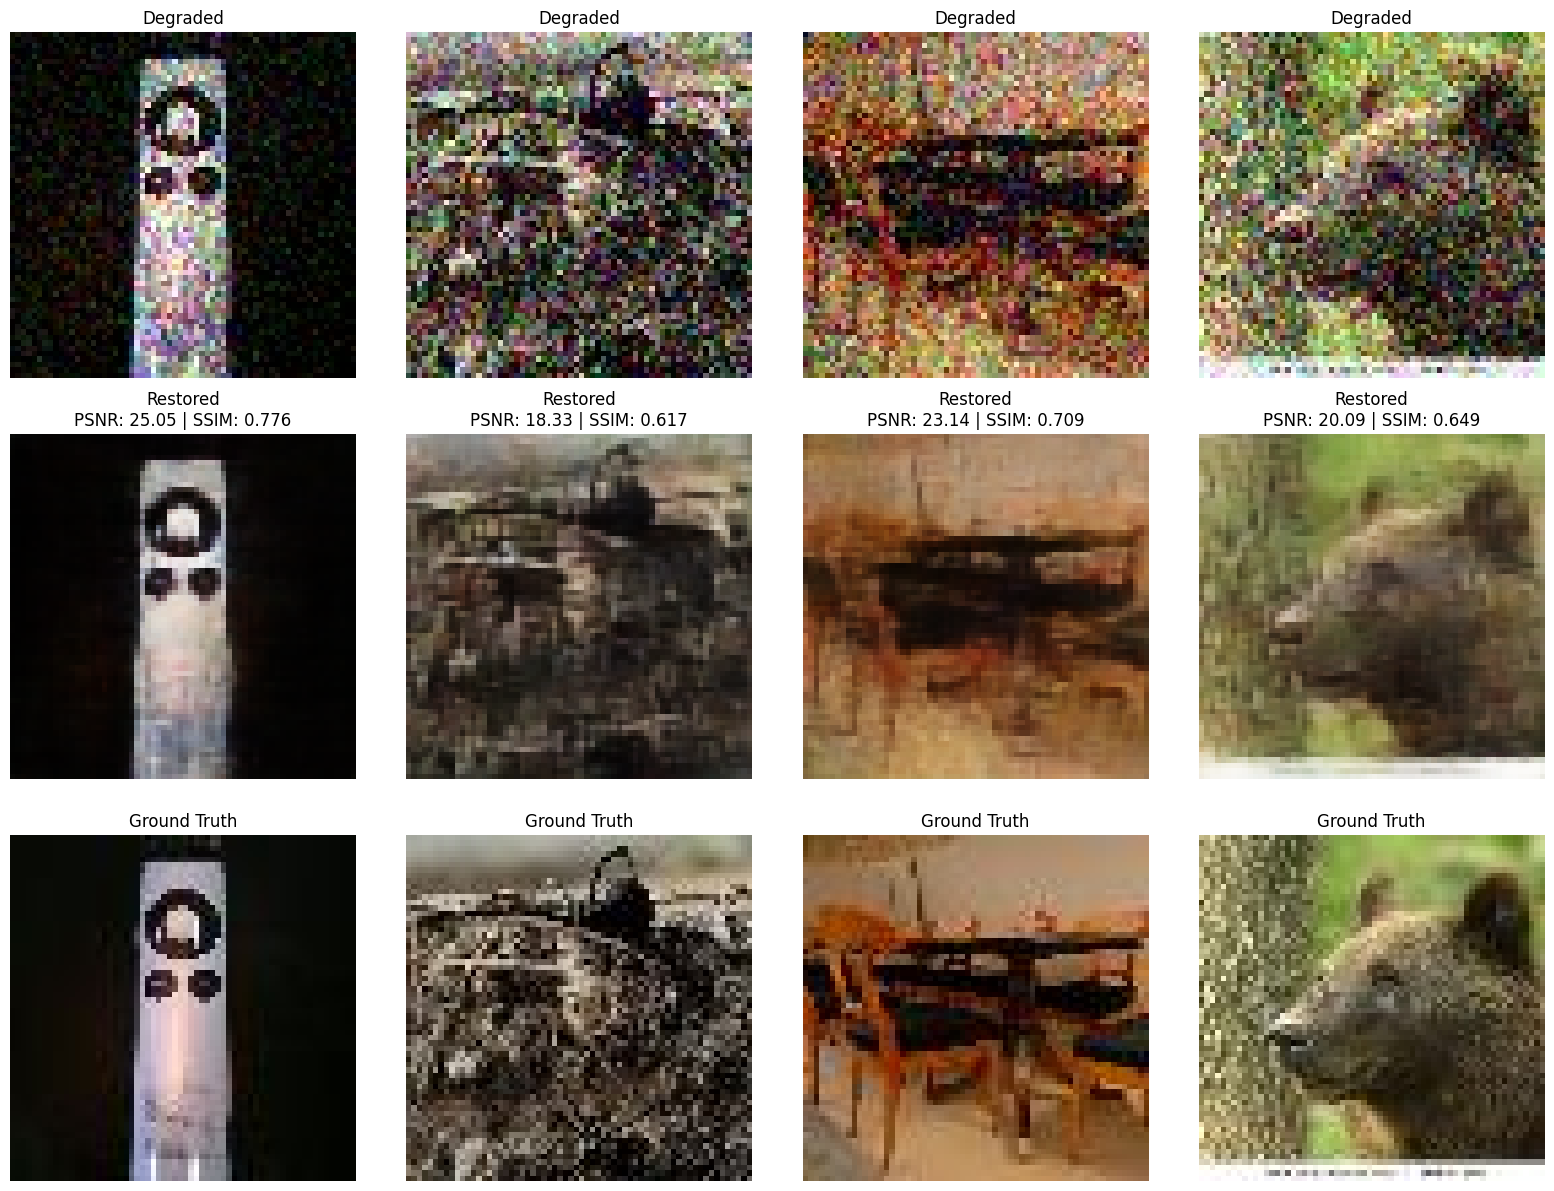

In [15]:
# 데이터 로드 및 시각화 (Tiny-ImageNet-C는 64x64)
transform = get_default_transform(image_size=64, train=False)

# corruption category 도메인 우선 테스트
domains_to_test = [
    ('imagenet-noise', DATA_ROOT / 'imagenet-c'),
    ('imagenet-blur', DATA_ROOT / 'imagenet-c'),
    ('imagenet-weather', DATA_ROOT / 'imagenet-c'),
    ('ldct', DATA_ROOT / 'ldct'),
    ('dibco', DATA_ROOT / 'dibco'),
    ('fmd', DATA_ROOT / 'fmd'),
]

for domain, path in domains_to_test:
    if path.exists():
        print(f"\n{'='*50}")
        print(f"📷 {domain.upper()} 복원 결과")
        print(f"{'='*50}")
        
        try:
            # LDCT는 test split 사용
            split = 'test' if domain == 'ldct' else 'train'
            dataset = get_dataset(domain, str(path), split=split, transform=transform)
            if len(dataset) > 0:
                print(f"Loaded {len(dataset)} samples")
                visualize_restoration(model, dataset, n_samples=4, device=device)
                break
        except Exception as e:
            print(f"Error loading {domain}: {e}")
            continue
else:
    print("사용 가능한 데이터셋이 없습니다.")

## 4. 열화 표현 (z_d) t-SNE 시각화

In [16]:
def extract_degradation_features(model, datasets, n_samples_per_domain=100, device='cpu'):
    """각 도메인에서 열화 표현 추출"""
    model.eval()
    
    all_features = []
    all_labels = []
    
    for domain_idx, (name, dataset) in enumerate(datasets.items()):
        if len(dataset) == 0:
            continue
        
        n = min(n_samples_per_domain, len(dataset))
        indices = np.random.choice(len(dataset), n, replace=False)
        
        for idx in indices:
            item = dataset[idx]
            degraded = item['degraded'].unsqueeze(0).to(device)
            
            with torch.no_grad():
                z_d, _ = model.encode_degradation(degraded)
            
            all_features.append(z_d.cpu().numpy().flatten())
            all_labels.append(name)
    
    return np.array(all_features), all_labels


def plot_tsne_visualization(features, labels, title="t-SNE of Degradation Representations"):
    """t-SNE 시각화"""
    from sklearn.manifold import TSNE
    
    # t-SNE 적용
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    features_2d = tsne.fit_transform(features)
    
    # 시각화
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    plt.figure(figsize=(10, 8))
    
    for label, color in zip(unique_labels, colors):
        mask = [l == label for l in labels]
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            c=[color],
            label=label.upper(),
            alpha=0.7,
            s=50
        )
    
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

imagenet-noise: 16371 samples
imagenet-blur: 16371 samples
imagenet-weather: 16371 samples
dibco: 9 samples
fmd: 3000 samples

열화 표현 추출 중...
총 209 샘플 추출 완료


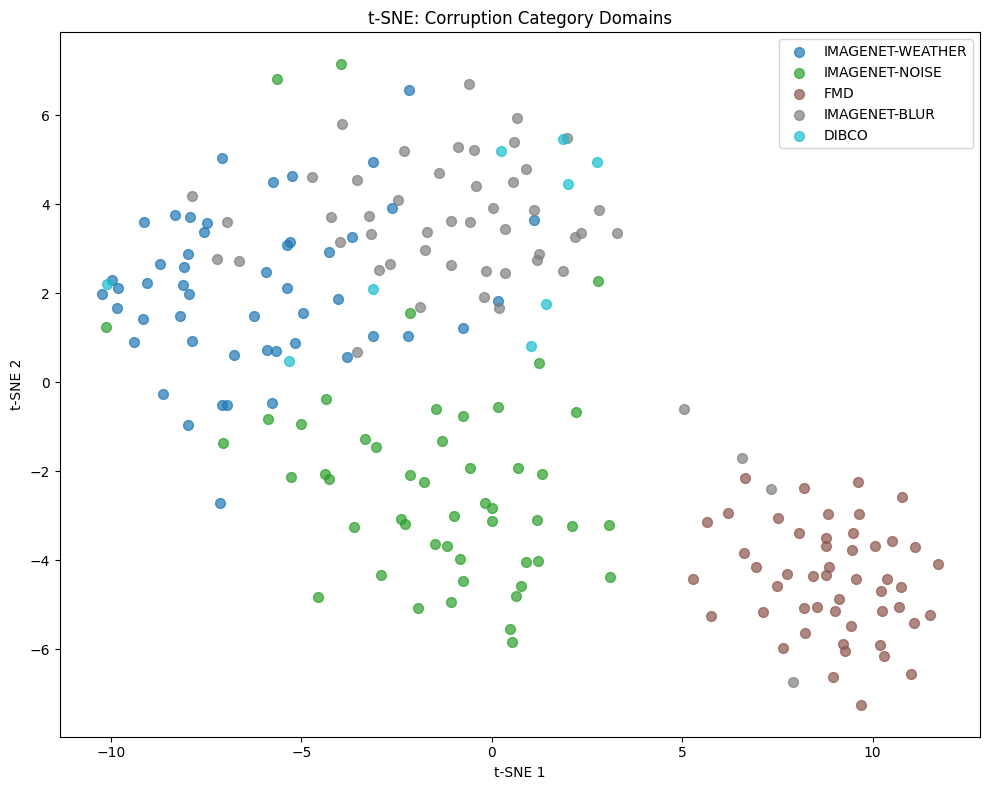

In [17]:
# 여러 도메인의 데이터셋 로드 (corruption category 포함)
datasets = {}
transform = get_default_transform(image_size=64, train=False)

# Corruption category 도메인 (ImageNet-C 하위 분류)
domain_configs = [
    ('imagenet-noise', DATA_ROOT / 'imagenet-c', 'train'),
    ('imagenet-blur', DATA_ROOT / 'imagenet-c', 'train'),
    ('imagenet-weather', DATA_ROOT / 'imagenet-c', 'train'),
    ('ldct', DATA_ROOT / 'ldct', 'test'),
    ('dibco', DATA_ROOT / 'dibco', 'train'),
    ('fmd', DATA_ROOT / 'fmd', 'train'),
]

for name, path, split in domain_configs:
    if path.exists():
        try:
            ds = get_dataset(name, str(path), split=split, transform=transform)
            if len(ds) > 0:
                datasets[name] = ds
                print(f"{name}: {len(ds)} samples")
        except Exception as e:
            print(f"{name}: Error - {e}")

if len(datasets) >= 2:
    print("\n열화 표현 추출 중...")
    features, labels = extract_degradation_features(model, datasets, n_samples_per_domain=50, device=device)
    print(f"총 {len(features)} 샘플 추출 완료")
    
    plot_tsne_visualization(features, labels, title="t-SNE: Corruption Category Domains")
else:
    print("t-SNE 시각화를 위해서는 최소 2개 도메인의 데이터가 필요합니다.")

## 5. Cross-Domain Transfer 시각화

In [18]:
def visualize_transfer(model, source_dataset, target_dataset, device='cpu'):
    """Cross-domain transfer 결과 시각화"""
    model.eval()
    
    if len(source_dataset) == 0 or len(target_dataset) == 0:
        print("데이터셋이 비어있습니다.")
        return
    
    # 랜덤 샘플 선택
    source_idx = np.random.randint(len(source_dataset))
    target_idx = np.random.randint(len(target_dataset))
    
    source_item = source_dataset[source_idx]
    target_item = target_dataset[target_idx]
    
    source_img = source_item['degraded'].unsqueeze(0).to(device)
    target_img = target_item['degraded'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Source 복원
        source_restored = model.restore(source_img).squeeze(0).cpu()
        # Target 복원
        target_restored = model.restore(target_img).squeeze(0).cpu()
        # 열화 전이: source의 열화를 target에 적용
        transferred = model.transfer_degradation(source_img, target_img).squeeze(0).cpu()
    
    # 시각화
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    def to_numpy(x):
        return (x.permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    
    # Source row
    axes[0, 0].imshow(to_numpy(source_item['degraded']))
    axes[0, 0].set_title('Source (Degraded)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(to_numpy(source_restored))
    axes[0, 1].set_title('Source Restored')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(to_numpy(source_item['clean']))
    axes[0, 2].set_title('Source GT')
    axes[0, 2].axis('off')
    
    # Target row
    axes[1, 0].imshow(to_numpy(target_item['degraded']))
    axes[1, 0].set_title('Target (Degraded)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(to_numpy(target_restored))
    axes[1, 1].set_title('Target Restored')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(to_numpy(transferred))
    axes[1, 2].set_title('Transfer: Source→Target')
    axes[1, 2].axis('off')
    
    plt.suptitle('Cross-Domain Degradation Transfer', fontsize=14)
    plt.tight_layout()
    plt.show()

Transfer: IMAGENET-NOISE → IMAGENET-BLUR


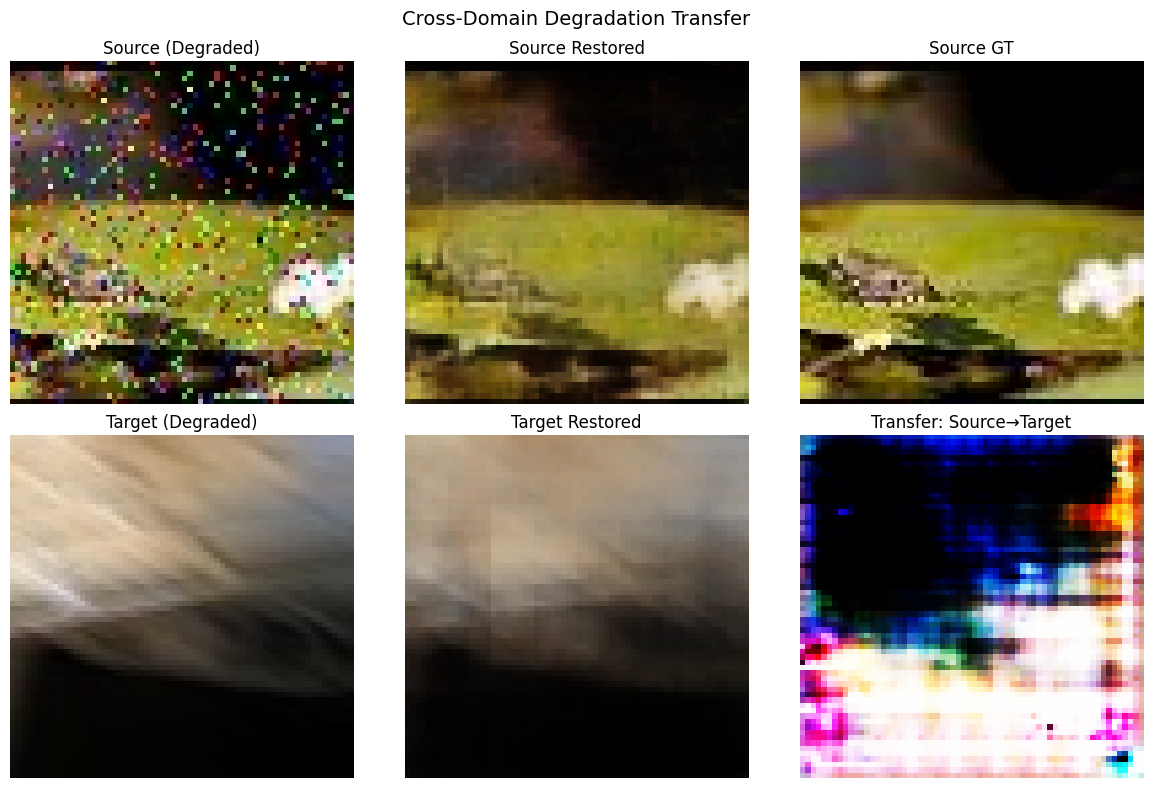

In [19]:
# Cross-domain transfer 시각화
if len(datasets) >= 2:
    domain_names = list(datasets.keys())
    source_name, target_name = domain_names[0], domain_names[1]
    
    print(f"Transfer: {source_name.upper()} → {target_name.upper()}")
    visualize_transfer(model, datasets[source_name], datasets[target_name], device=device)
else:
    print("Cross-domain transfer를 위해서는 최소 2개 도메인의 데이터가 필요합니다.")

## 6. 메트릭 요약

In [20]:
def evaluate_domain(model, dataset, n_samples=50, device='cpu'):
    """도메인별 메트릭 계산"""
    model.eval()
    
    if len(dataset) == 0:
        return None
    
    n = min(n_samples, len(dataset))
    indices = np.random.choice(len(dataset), n, replace=False)
    
    psnrs, ssims = [], []
    
    for idx in indices:
        item = dataset[idx]
        degraded = item['degraded'].unsqueeze(0).to(device)
        clean = item['clean'].unsqueeze(0).to(device)
        
        with torch.no_grad():
            restored = model.restore(degraded)
        
        # [0, 1] 범위로 변환
        restored_01 = (restored + 1) / 2
        clean_01 = (clean + 1) / 2
        
        psnrs.append(compute_psnr(restored_01, clean_01).item())
        ssims.append(compute_ssim(restored_01, clean_01).item())
    
    return {
        'psnr_mean': np.mean(psnrs),
        'psnr_std': np.std(psnrs),
        'ssim_mean': np.mean(ssims),
        'ssim_std': np.std(ssims),
    }

# 모든 도메인 평가
print("\n" + "="*60)
print("📊 도메인별 성능 요약")
print("="*60)
print(f"{'Domain':<12} {'PSNR':<20} {'SSIM':<20}")
print("-"*60)

for name, dataset in datasets.items():
    metrics = evaluate_domain(model, dataset, n_samples=30, device=device)
    if metrics:
        print(f"{name.upper():<12} {metrics['psnr_mean']:.2f} ± {metrics['psnr_std']:.2f}       {metrics['ssim_mean']:.4f} ± {metrics['ssim_std']:.4f}")


📊 도메인별 성능 요약
Domain       PSNR                 SSIM                
------------------------------------------------------------
IMAGENET-NOISE 20.41 ± 1.74       0.7079 ± 0.0471
IMAGENET-BLUR 16.97 ± 2.31       0.4643 ± 0.1235
IMAGENET-WEATHER 14.60 ± 1.72       0.6285 ± 0.0821
DIBCO        6.62 ± 5.64       0.3347 ± 0.2365
FMD          28.80 ± 6.13       0.6847 ± 0.0886
